

## Modelo SVM - Dataset vector promedio pesado por IDF

In [ ]:
import pandas as pd
import pycaret
from sklearn.metrics import roc_auc_score
from pycaret.classification import *
import joblib
from sklearn import model_selection

import locale
locale.setlocale(locale.LC_ALL,'es_ES.UTF-8')
from datetime import datetime as dt


#Configuracion pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)
pd.set_option('display.width', 2000)
pd.set_option('display.float_format', '{:20,.2f}'.format)
pd.set_option('display.max_colwidth', None)

# Prepara dataset para entrenamiento

# VECTOR PROMEDIOS PESADOS POR IDF

In [ ]:
df=joblib.load('./datasets/2_VECTOR_PROM_PESADO')

In [ ]:
data=pd.DataFrame(df['vector_prom_pesado'].to_list())
data['label']=df['topico'].values
data['fecha']=df['fecha'].values

# Se le especifica el tipo a las columnas
data['label']=data['label'].astype('category')
data['fecha']=data['fecha'].map(lambda s:dt.strptime(s, '%d de %B de %Y - %H:%M'))

## Train-Test separados por fechas

In [ ]:
data=data.sort_values(by='fecha')
data.reset_index(drop=True,inplace=True)

In [ ]:
train_test_frac=0.8
rows=round(data.shape[0]*train_test_frac)
fecha_corte=data.loc[rows,'fecha']

train_date=data[data['fecha']<=fecha_corte].reset_index(drop=True)
test_date=data[data['fecha']>fecha_corte].reset_index(drop=True)

In [ ]:
print('FECHAS TRAIN:'+str(train_date['fecha'].min())+ '-'+str(train_date['fecha'].max()))
print('FECHAS TEST:'+str(test_date['fecha'].min())+ '-'+str(test_date['fecha'].max()))

FECHAS TRAIN:2018-03-08 01:59:00-2021-11-30 00:48:00
FECHAS TEST:2021-11-30 02:40:00-2022-08-31 11:04:00


### Registros por etiquetas en train

In [ ]:
train_date['label'].value_counts()

el-pais     8537
sociedad    8083
economia    5906
el-mundo    5117
Name: label, dtype: int64

### Registros por etiquetas en test

In [ ]:
test_date['label'].value_counts()

sociedad    2400
el-pais     2145
economia    1354
el-mundo    1007
Name: label, dtype: int64

## Train-Test mezclados

In [ ]:
train_shuffle, test_shuffle = model_selection.train_test_split(data, test_size=0.2,stratify=data['label'],random_state=2016,shuffle=True)

In [ ]:
print('FECHAS TRAIN:'+str(train_shuffle['fecha'].min())+ '-'+str(train_shuffle['fecha'].max()))
print('FECHAS TEST:'+str(test_shuffle['fecha'].min())+ '-'+str(test_shuffle['fecha'].max()))

FECHAS TRAIN:2018-03-08 01:59:00-2022-08-31 11:04:00
FECHAS TEST:2018-03-10 01:11:00-2022-08-31 07:23:00


In [ ]:
train_shuffle['label'].value_counts()

el-pais     8546
sociedad    8386
economia    5808
el-mundo    4899
Name: label, dtype: int64

In [ ]:
test_shuffle['label'].value_counts()

el-pais     2136
sociedad    2097
economia    1452
el-mundo    1225
Name: label, dtype: int64

**Se deben revisar las proporciones**

## Normalización de cantidad de registros por secciones

In [ ]:
secciones=['economia','sociedad','el-mundo','el-pais']
train_date_norm=pd.DataFrame([],columns=train_date.columns)
test_date_norm=pd.DataFrame([],columns=train_date.columns)

train_shuffle_norm=pd.DataFrame([],columns=train_shuffle.columns)
test_shuffle_norm=pd.DataFrame([],columns=train_shuffle.columns)


for seccion in secciones:
    train_min=min(sum(train_date['label']==seccion),sum(train_shuffle['label']==seccion))
    test_min=min(sum(test_date['label']==seccion),sum(test_shuffle['label']==seccion))
    
    train_date_norm=pd.concat([train_date_norm,train_date[train_date['label']==seccion].sample(train_min)],axis=0)
    train_shuffle_norm=pd.concat([train_shuffle_norm,train_shuffle[train_shuffle['label']==seccion].sample(train_min)],axis=0)
    
    test_date_norm=pd.concat([test_date_norm,test_date[test_date['label']==seccion].sample(test_min)],axis=0)
    test_shuffle_norm=pd.concat([test_shuffle_norm,test_shuffle[test_shuffle['label']==seccion].sample(test_min)],axis=0)    

## Verifiacion dataset normalizados

### Separados cronologicamente

In [ ]:
print('FECHAS TRAIN:'+str(train_date_norm['fecha'].min())+ '-'+str(train_date_norm['fecha'].max()))
print('FECHAS TEST:'+str(test_date_norm['fecha'].min())+ '-'+str(test_date_norm['fecha'].max()))

FECHAS TRAIN:2018-03-08 01:59:00-2021-11-30 00:48:00
FECHAS TEST:2021-11-30 02:40:00-2022-08-31 11:04:00


In [ ]:
train_date_norm['label'].value_counts()

el-pais     8537
sociedad    8083
economia    5808
el-mundo    4899
Name: label, dtype: int64

In [ ]:
test_date_norm['label'].value_counts()

el-pais     2136
sociedad    2097
economia    1354
el-mundo    1007
Name: label, dtype: int64

### Separados al azar

In [ ]:
print('FECHAS TRAIN:'+str(train_shuffle_norm['fecha'].min())+ '-'+str(train_shuffle_norm['fecha'].max()))
print('FECHAS TEST:'+str(test_shuffle_norm['fecha'].min())+ '-'+str(test_shuffle_norm['fecha'].max()))

FECHAS TRAIN:2018-03-08 01:59:00-2022-08-31 11:04:00
FECHAS TEST:2018-03-10 01:11:00-2022-08-31 07:23:00


In [ ]:
train_shuffle_norm['label'].value_counts()

el-pais     8537
sociedad    8083
economia    5808
el-mundo    4899
Name: label, dtype: int64

In [ ]:
test_shuffle_norm['label'].value_counts()

el-pais     2136
sociedad    2097
economia    1354
el-mundo    1007
Name: label, dtype: int64

# Dataset ordenado por Fecha (Solo SVM)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, GridSearchCV
encoder = preprocessing.LabelEncoder()

In [ ]:
# Se transforma a numerica las clases
train_date['label_num'] = encoder.fit_transform(train_date['label'].values)
test_date['label_num'] = encoder.fit_transform(test_date['label'].values)

train_date[['label_num','label']].drop_duplicates()

,label_num,label
0,0,economia
1,1,el-mundo
3165,3,sociedad
5858,2,el-pais


## Busqueda de hiperparametros

In [ ]:
from sklearn.metrics import fbeta_score, make_scorer

In [ ]:
# Debido a limitaciones computacionales se realiza la busqueda de hiperparametros con un subset del dataset
params_grid = [{'kernel': ['rbf']   , 'C': [1,2,5,10,50,100]},
               {'kernel': ['linear'], 'C': [1,2,5,10,50,100]}]

X = train_date.drop(columns=['label','fecha','label_num']).sample(5000)
y = train_date.iloc[X.index]['label_num']

svm_model = GridSearchCV(SVC(), params_grid, cv=3)
svm_model.fit(X.values, y.values)

GridSearchCV(cv=3, estimator=SVC(),
             param_grid=[{'C': [1, 2, 5, 10, 50, 100], 'kernel': ['rbf']},
                         {'C': [1, 2, 5, 10, 50, 100], 'kernel': ['linear']}])

In [ ]:
print("Los mejores parámetros son: ",svm_model.best_params_)

Los mejores parámetros son:  {'C': 10, 'kernel': 'rbf'}


### Se entrena con todo el dataset de tranin y se seleccionan los mejores hipeparametros

In [ ]:
import pickle

In [ ]:
# X = train_date.drop(columns=['label','fecha','label_num']).sample(5000) # Opcion para hacerlo rápido
# y = train_date.iloc[X.index]['label_num']

X = train_date.drop(columns=['label','fecha','label_num'])
y = train_date['label_num']

final_model = SVC(kernel='rbf', C=5,probability=True)
final_model.fit(X, y)

SVC(C=5, probability=True)

In [ ]:
pickle.dump(final_model, open('svm_date_prom_idf', 'wb'))

## Prueba con dataset de *TEST*

In [ ]:
X_test = test_date.drop(columns=['label','fecha','label_num'])
y_test = test_date['label_num']

In [ ]:
# Predice etiqueta (selecciona la de mayor probabilidad de las 4 secciones)
Y_pred = final_model.predict(X_test)
Y_pred_label = list(encoder.inverse_transform(Y_pred)) # Lo vuelve a codificar con el nombre

#Calcula probabilidad por seccion
Y_prob= final_model.predict_proba(X_test)

# Agrega probabilidad por seccion
df_sol=pd.concat(
            [test_date.reset_index(drop=True)[['label','label_num']],
             pd.DataFrame(Y_prob,columns=['prob_economia','prob_el-mundo','prob_el-pais','prob_sociedad'])],axis=1)

# Agrega etiqueta de predicciones
df_sol=pd.concat([df_sol,pd.DataFrame(Y_pred_label,columns=['Label_ped'])],axis=1)

In [ ]:
df_sol.head()

,label,label_num,prob_economia,prob_el-mundo,prob_el-pais,prob_sociedad,Label_ped
0,el-pais,2,0.02,0.00,0.97,0.01,el-pais
1,el-pais,2,0.17,0.00,0.82,0.01,el-pais
2,sociedad,3,0.00,0.00,0.01,0.99,sociedad
3,el-mundo,1,0.00,1.00,0.00,0.00,el-mundo
4,economia,0,0.94,0.01,0.02,0.03,economia


In [ ]:
auc=[]
for i,seccion in enumerate(['economia','el-mundo','el-pais','sociedad']):
    auc.append(roc_auc_score((df_sol['label']==seccion).astype(int),df_sol['prob_'+seccion]))
    print("AUC: "+seccion+": "+str(auc[i]))

AUC: economia: 0.9841099485354526
AUC: el-mundo: 0.9835186580863939
AUC: el-pais: 0.9576962979609482
AUC: sociedad: 0.965479730729398


In [ ]:
print("La AUC One oVer Rest es: "+str(sum(auc)/4)) # En TEST

La AUC One oVer Rest es: 0.9727011588280482


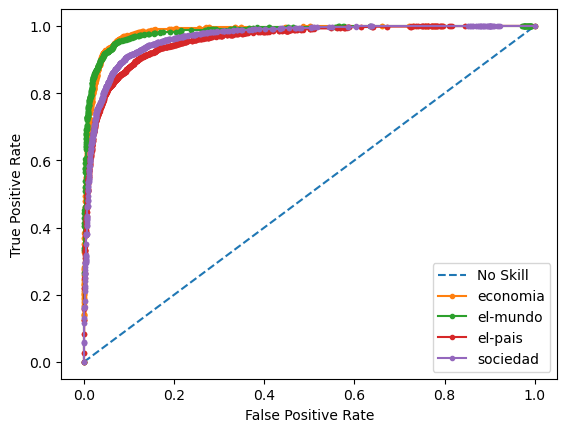

In [ ]:
auc=[]
for i,seccion in enumerate(['economia','el-mundo','el-pais','sociedad']):  
    fpr, tpr, thresholds = roc_curve((df_sol['label']==seccion).astype(int), df_sol['prob_'+seccion])

    if i==0:
        plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label=seccion)

    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    # show the plot
    plt.rcParams['figure.figsize'] = (8, 6)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
confusion = confusion_matrix(df_sol['label'], df_sol['Label_ped'])

<AxesSubplot:>

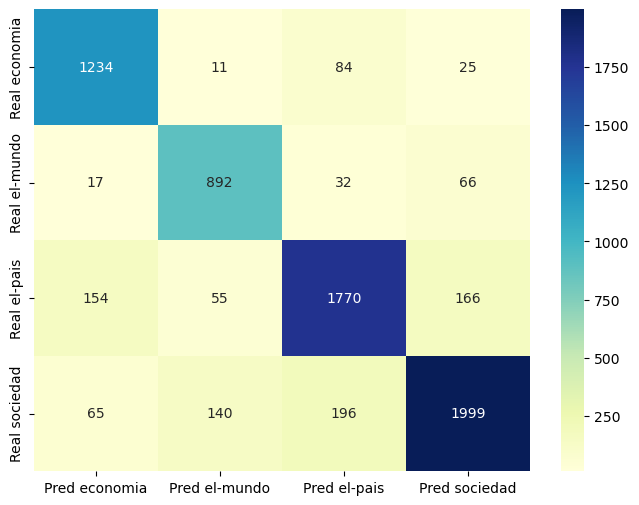

In [ ]:
cm_matrix = pd.DataFrame(data=confusion, columns=['Pred economia', 'Pred el-mundo','Pred el-pais','Pred sociedad'], 
                                 index=['Real economia', 'Real el-mundo','Real el-pais','Real sociedad'])
sns.heatmap(cm_matrix, annot=True, fmt="d", cmap='YlGnBu')

In [ ]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(df_sol['label'], df_sol['Label_ped'], target_names=['economia', 'el-mundo', 'el-pais','sociedad']))
# pred_lr['label'].value_counts() #Sirve para chequear las clases


Classification Report

              precision    recall  f1-score   support

    economia       0.84      0.91      0.87      1354
    el-mundo       0.81      0.89      0.85      1007
     el-pais       0.85      0.83      0.84      2145
    sociedad       0.89      0.83      0.86      2400

    accuracy                           0.85      6906
   macro avg       0.85      0.86      0.85      6906
weighted avg       0.86      0.85      0.85      6906



# Con el dataset desordenado

In [ ]:
# Se transforma a numerica las clases
train_shuffle['label_num'] = encoder.fit_transform(train_shuffle['label'].values)
test_shuffle['label_num'] = encoder.fit_transform(test_shuffle['label'].values)

train_shuffle[['label_num','label']].drop_duplicates()

,label_num,label
16963,3,sociedad
20660,2,el-pais
5572,0,economia
13165,1,el-mundo


# Entrenamiento del modelo

In [ ]:
X_s = train_shuffle.drop(columns=['label','fecha','label_num'])
y_s = train_shuffle['label_num']

final_model_s = SVC(kernel='rbf', C=5,probability=True)
final_model_s.fit(X_s, y_s)

SVC(C=5, probability=True)

In [ ]:
pickle.dump(final_model_s, open('svm_shuffle_prom_idf', 'wb'))

## Pruebas en Test

In [ ]:
X_test_s = test_shuffle.drop(columns=['label','fecha','label_num'])
y_test_s = test_shuffle['label_num']

In [ ]:
# Predice etiqueta (selecciona la de mayor probabilidad de las 4 secciones)
Y_pred = final_model_s.predict(X_test_s)
Y_pred_label = list(encoder.inverse_transform(Y_pred)) # Lo vuelve a codificar con el nombre

#Calcula probabilidad por seccion
Y_prob= final_model_s.predict_proba(X_test_s)

# Agrega probabilidad por seccion
df_sol_s=pd.concat(
            [test_shuffle.reset_index(drop=True)[['label','label_num']],
             pd.DataFrame(Y_prob,columns=['prob_economia','prob_el-mundo','prob_el-pais','prob_sociedad'])],axis=1)

# Agrega etiqueta de predicciones
df_sol_s=pd.concat([df_sol_s,pd.DataFrame(Y_pred_label,columns=['Label_ped'])],axis=1)

In [ ]:
auc=[]
for i,seccion in enumerate(['economia','el-mundo','el-pais','sociedad']):
    auc.append(roc_auc_score((df_sol_s['label']==seccion).astype(int),df_sol_s['prob_'+seccion]))
    print("AUC: "+seccion+": "+str(auc[i]))

AUC: economia: 0.9843860252143339
AUC: el-mundo: 0.982410281262901
AUC: el-pais: 0.9524896089774669
AUC: sociedad: 0.9585515940425614


In [ ]:
print("La AUC One oVer Rest es: "+str(sum(auc)/4)) # En TEST

La AUC One oVer Rest es: 0.9694593773743158


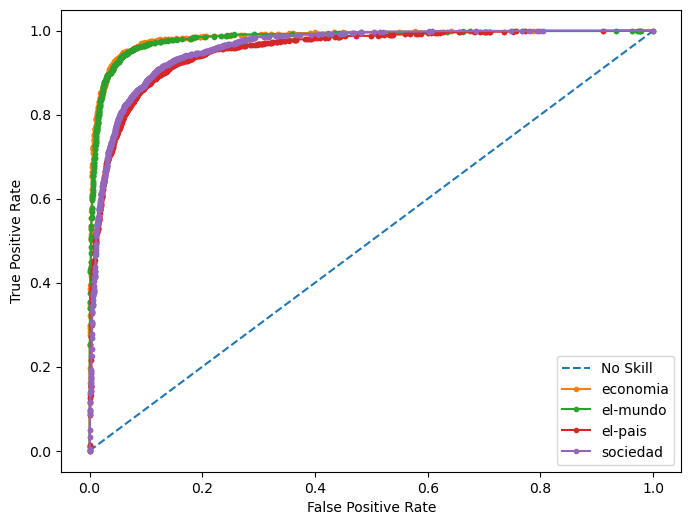

In [ ]:
auc=[]
for i,seccion in enumerate(['economia','el-mundo','el-pais','sociedad']):  
    fpr, tpr, thresholds = roc_curve((df_sol_s['label']==seccion).astype(int), df_sol_s['prob_'+seccion])

    if i==0:
        plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label=seccion)

    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    # show the plot
    plt.rcParams['figure.figsize'] = (8, 6)
plt.show()

<AxesSubplot:>

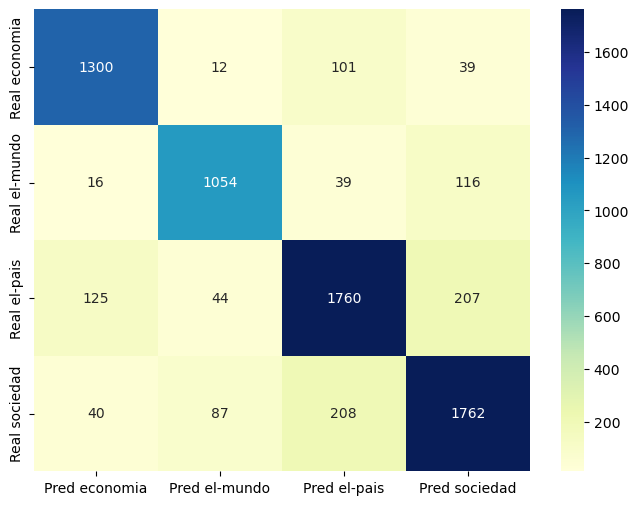

In [ ]:
confusion = confusion_matrix(df_sol_s['label'], df_sol_s['Label_ped'])

cm_matrix = pd.DataFrame(data=confusion, columns=['Pred economia', 'Pred el-mundo','Pred el-pais','Pred sociedad'], 
                                 index=['Real economia', 'Real el-mundo','Real el-pais','Real sociedad'])
sns.heatmap(cm_matrix, annot=True, fmt="d", cmap='YlGnBu')

In [ ]:
print('\nClassification Report\n')
print(classification_report(df_sol_s['label'], df_sol_s['Label_ped'], target_names=['economia', 'el-mundo', 'el-pais','sociedad']))
# pred_lr['label'].value_counts() #Sirve para chequear las clases


Classification Report

              precision    recall  f1-score   support

    economia       0.88      0.90      0.89      1452
    el-mundo       0.88      0.86      0.87      1225
     el-pais       0.83      0.82      0.83      2136
    sociedad       0.83      0.84      0.83      2097

    accuracy                           0.85      6910
   macro avg       0.86      0.85      0.86      6910
weighted avg       0.85      0.85      0.85      6910

